In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=b688aef5653e3acad3c2058588d8bc68444eca8d65765d868677e8c0cbe0a6f0
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 6.8 MB/s eta 0:00:00


                ts        src_ip  src_port         dst_ip  dst_port proto  \
461038  1556340862  192.168.1.32     33108  176.28.50.165        80   tcp   
461039  1556423390  192.168.1.33     37242  34.230.157.88       443   tcp   
461040  1556436603  192.168.1.37      4444  192.168.1.193     49178   tcp   
461041  1556540442  192.168.1.31     60816  104.98.29.100       443   tcp   
461042  1556540442  192.168.1.31     41054  151.101.24.64       443   tcp   

       service    duration  src_bytes  dst_bytes  ... http_response_body_len  \
461038       -    0.000000          0          0  ...                      0   
461039       -    0.000000          0          0  ...                      0   
461040       -  290.371539     101568       2592  ...                      0   
461041       -   23.190902         32         31  ...                      0   
461042       -   22.872314         32         31  ...                      0   

        http_status_code  http_user_agent  http_orig_mim

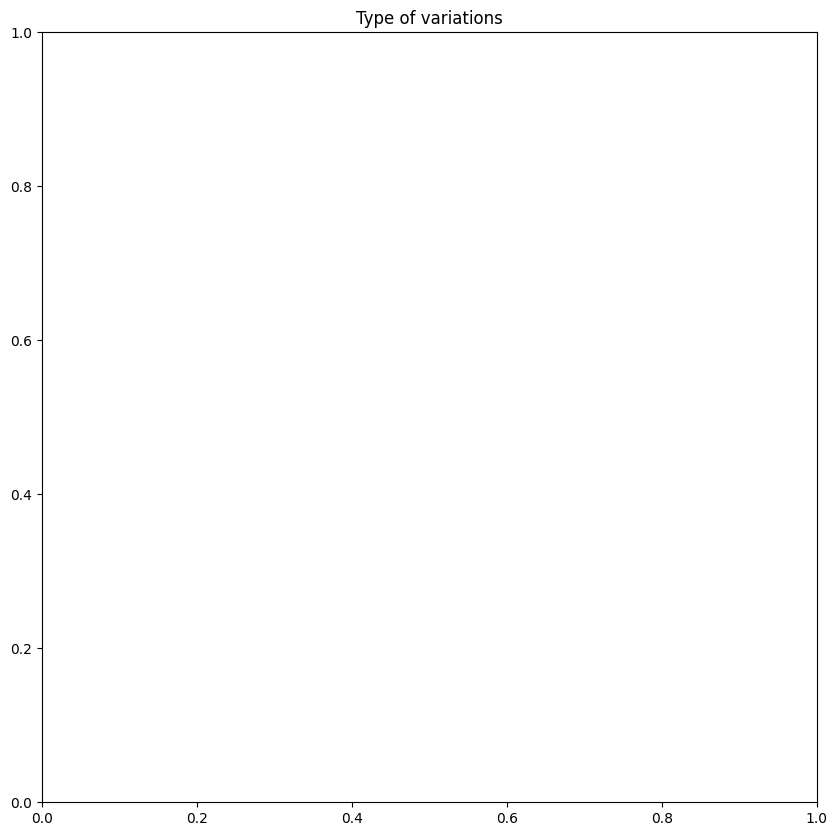

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461043 entries, 0 to 461042
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ts                      461043 non-null  int64  
 1   src_ip                  461043 non-null  object 
 2   src_port                461043 non-null  int64  
 3   dst_ip                  461043 non-null  object 
 4   dst_port                461043 non-null  int64  
 5   proto                   461043 non-null  object 
 6   service                 461043 non-null  object 
 7   duration                461043 non-null  float64
 8   src_bytes               461043 non-null  int64  
 9   dst_bytes               461043 non-null  int64  
 10  conn_state              461043 non-null  object 
 11  missed_bytes            461043 non-null  int64  
 12  src_pkts                461043 non-null  int64  
 13  src_ip_bytes            461043 non-null  int64  
 14  dst_pkts            

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, mean_absolute_error, r2_score, mean_squared_error,
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import warnings
import lime
import lime.lime_tabular
import shap

warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('Train_Test_Network.csv')
columns = ['ts',
 'src_ip',
 'src_port',
 'dst_ip',
 'dst_port',
 'proto',
 'service',
 'duration',
 'src_bytes',
 'dst_bytes',
 'conn_state',
 'missed_bytes',
 'src_pkts',
 'src_ip_bytes',
 'dst_pkts',
 'dst_ip_bytes',
 'dns_query',
 'dns_qclass',
 'dns_qtype',
 'dns_rcode',
 'dns_AA',
 'dns_RD',
 'dns_RA',
 'dns_rejected',
 'ssl_version',
 'ssl_cipher',
 'ssl_resumed',
 'ssl_established',
 'ssl_subject',
 'ssl_issuer',
 'http_trans_depth',
 'http_method',
 'http_uri',
 'http_version',
 'http_request_body_len',
 'http_response_body_len',
 'http_status_code',
 'http_user_agent',
 'http_orig_mime_types',
 'http_resp_mime_types',
 'weird_name',
 'weird_addl',
 'weird_notice',
 'label',
 'type']
data.columns = columns

# Display the last few rows of the dataset
print(data.tail())

# Duplicate the data for testing purposes
data_test = data.copy()

# Display the unique labels
print(data['type'].unique())

# Change attack labels to their respective attack class
def change_label(df):
    df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
    df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
    df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
    df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

change_label(data)
print(data.label.unique())

# Display value counts of labels
print(data.label.value_counts())

# Check for any missing values
print(data.isnull().values.any())

# Plot the label variations
plt.figure(figsize=(10, 10))
explode = tuple([0.1] + [0]*(len(data['type'].unique())-1))  # set the first slice to explode
# data['type'].value_counts().plot(kind='pie', explode=explode, startangle=90, autopct='%1.1f%%')
# Generate the value counts
value_counts = data['type'].value_counts()

# Generate the explode sequence with the same length as the unique types
explode = [0.1 if i == 0 else 0 for i in range(len(value_counts))]
plt.title('Type of variations')
plt.show()

# Display info and the first 50 rows of the dataset
print(data.info())
print(data.head(50))

# Encode categorical features
le = LabelEncoder()
data['proto'] = le.fit_transform(data['proto'])
data['service'] = le.fit_transform(data['service'])
data['conn_state'] = le.fit_transform(data['conn_state'])
data['weird_name'] = le.fit_transform(data['weird_name'])
data['type'] = le.fit_transform(data['type'])
data['src_ip'] = le.fit_transform(data['src_ip'])
data['dst_ip'] = le.fit_transform(data['dst_ip'])
data['dns_query'] = le.fit_transform(data['dns_query'])
data['dns_AA'] = le.fit_transform(data['dns_AA'])
data['dns_RD'] = le.fit_transform(data['dns_RD'])
data['dns_RA'] = le.fit_transform(data['dns_RA'])
data['dns_rejected'] = le.fit_transform(data['dns_rejected'])
data['ssl_version'] = le.fit_transform(data['ssl_version'])
data['ssl_cipher'] = le.fit_transform(data['ssl_cipher'])
data['ssl_resumed'] = le.fit_transform(data['ssl_resumed'])
data['ssl_established'] = le.fit_transform(data['ssl_established'])
data['ssl_subject'] = le.fit_transform(data['ssl_subject'])
data['ssl_issuer'] = le.fit_transform(data['ssl_issuer'])
data['http_trans_depth'] = le.fit_transform(data['http_trans_depth'])
data['http_method'] = le.fit_transform(data['http_method'])
data['http_uri'] = le.fit_transform(data['http_uri'])
data['http_version'] = le.fit_transform(data['http_version'])
data['http_user_agent'] = le.fit_transform(data['http_user_agent'])
data['http_orig_mime_types'] = le.fit_transform(data['http_orig_mime_types'])
data['http_resp_mime_types'] = le.fit_transform(data['http_resp_mime_types'])
data['weird_addl'] = le.fit_transform(data['weird_addl'])
data['weird_notice'] = le.fit_transform(data['weird_notice'])

data_test['proto'] = le.fit_transform(data_test['proto'])
data_test['service'] = le.fit_transform(data_test['service'])
data_test['conn_state'] = le.fit_transform(data_test['conn_state'])
data_test['weird_name'] = le.fit_transform(data_test['weird_name'])
data_test['type'] = le.fit_transform(data_test['type'])
data_test['src_ip'] = le.fit_transform(data_test['src_ip'])
data_test['dst_ip'] = le.fit_transform(data_test['dst_ip'])
data_test['dns_query'] = le.fit_transform(data['dns_query'])
data_test['dns_AA'] = le.fit_transform(data['dns_AA'])
data_test['dns_RD'] = le.fit_transform(data['dns_RD'])
data_test['dns_RA'] = le.fit_transform(data['dns_RA'])
data_test['dns_rejected'] = le.fit_transform(data['dns_rejected'])
data_test['ssl_version'] = le.fit_transform(data['ssl_version'])
data_test['ssl_cipher'] = le.fit_transform(data['ssl_cipher'])
data_test['ssl_resumed'] = le.fit_transform(data['ssl_resumed'])
data_test['ssl_established'] = le.fit_transform(data['ssl_established'])
data_test['ssl_subject'] = le.fit_transform(data['ssl_subject'])
data_test['ssl_issuer'] = le.fit_transform(data['ssl_issuer'])
data_test['http_trans_depth'] = le.fit_transform(data['http_trans_depth'])
data_test['http_method'] = le.fit_transform(data['http_method'])
data_test['http_uri'] = le.fit_transform(data['http_uri'])
data_test['http_version'] = le.fit_transform(data['http_version'])
data_test['http_user_agent'] = le.fit_transform(data['http_user_agent'])
data_test['http_orig_mime_types'] = le.fit_transform(data['http_orig_mime_types'])
data_test['http_resp_mime_types'] = le.fit_transform(data['http_resp_mime_types'])
data_test['weird_addl'] = le.fit_transform(data['weird_addl'])
data_test['weird_notice'] = le.fit_transform(data['weird_notice'])



# Check for non-finite values
# print(False in np.isfinite(data).values)

# Define cross-validation function
def cross_val(x_train, y_train, model):
    accuracies = cross_val_score(estimator=model, X=x_train, y=y_train, cv=5)
    return accuracies.mean()

# Define function to fit and evaluate a model
def fit_and_evaluate(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    model_pred = model.predict(x_test)
    model_cross = cross_val(x_train, y_train, model)
    return model_cross

# Define function to run an experiment with a model
def run_experiment(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print("R^2:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    report = classification_report(y_test, y_pred)
    print(report)

# Split the dataset into features and labels
x = data.drop(['type'], axis=1).values
y = data['type'].values

# Scale the dataset
for col in data.columns:
    try:
        data[col] = pd.to_numeric(data[col])
    except ValueError:
        print(f"Column '{col}' cannot be converted to numeric.")
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)

# Copy the training and testing sets for multiple experiments
x_traincpy = np.copy(x_train)
y_traincpy = np.copy(y_train)
x_testcpy = np.copy(x_test)
y_testcpy = np.copy(y_test)

# Logistic Regression
logr = LogisticRegression()
logr_cross = fit_and_evaluate(logr, x_traincpy, x_testcpy, y_traincpy, y_testcpy)
print('Logistic Regression Performance on the validation set: Cross Validation Score = %0.4f' % logr_cross)
y_pred = logr.predict(x_testcpy)
print("Accuracy on test dataset:", accuracy_score(y_testcpy, y_pred))

# Random Forest
random = RandomForestClassifier(n_estimators=100, criterion='entropy')
random_cross = fit_and_evaluate(random, x_traincpy, x_testcpy, y_traincpy, y_testcpy)
print('Random Forest Performance on the validation set: Cross Validation Score = %0.4f' % random_cross)
y_pred = random.predict(x_test)
print("Accuracy on test dataset:", accuracy_score(y_testcpy, y_pred))

# Define function to explain the model
def explain_model(model, x_train, explainer_type):
    if explainer_type == 'lime':
        explainer = lime.lime_tabular.LimeTabularExplainer(x_train, mode='classification', feature_names=data.drop(['label'], axis=1).columns)
    elif explainer_type == 'shap':
        explainer = shap.KernelExplainer(model.predict, x_train)
    else:
        raise ValueError("Invalid explainer type. Choose either 'lime' or 'shap'.")
    return explainer

# Further preprocessing
data_test = data_test.drop(data_test[data_test['dst_bytes'] > 1750].index)
data_test = data_test.drop(data_test[data_test['src_bytes'] > 717].index)
x_wo = data.drop(['type'], axis=1).values
y_wo = data['type'].values

# Scaling the dataset
ro_scaler = RobustScaler()
x_wo_scaled = ro_scaler.fit_transform(x_wo)
x_wo_scaled = MinMaxScaler().fit_transform(x_wo_scaled)

# Split the scaled dataset into training and testing sets
x_wo_train, x_wo_test, y_wo_train, y_wo_test = train_test_split(x_wo_scaled, y_wo, test_size=0.2, random_state=42)

# Prepare testing set
xl_wo_test = data_test.drop(['type'], axis=1).values
yl_wo_test = data_test['type'].values
xl_wo_test = MinMaxScaler().fit_transform(xl_wo_test)

# Copy the training and testing sets for multiple experiments
x_traincpy = np.copy(x_wo_train)
y_traincpy = np.copy(y_wo_train)
x_testcpy = np.copy(x_wo_test)
y_testcpy = np.copy(y_wo_test)

# Random Forest with the scaled dataset
random = RandomForestClassifier(n_estimators=10, criterion='entropy')
random_cross = fit_and_evaluate(random, x_traincpy, x_testcpy, y_traincpy, y_testcpy)
print('Random Forest Performance on the test set: Cross Validation Score = %0.4f' % random_cross)
y_pred = random.predict(xl_wo_test)
print("Accuracy:", accuracy_score(yl_wo_test, y_pred))





Model accuracy with top 2 representatives (Mutual Information): 0.9960415904130573
Model MCC with top 2 representatives (Mutual Information): 0.9930454559244833
Model accuracy with top 4 representatives (Mutual Information): 0.9985088183062887
Model MCC with top 4 representatives (Mutual Information): 0.9970730089015882
Model accuracy with top 6 representatives (Mutual Information): 0.9998237694361978
Model MCC with top 6 representatives (Mutual Information): 0.9994209364625305
Model accuracy with top 8 representatives (Mutual Information): 0.99987799422506
Model MCC with top 8 representatives (Mutual Information): 0.9996139654189914
Model accuracy with top 10 representatives (Mutual Information): 0.99987799422506
Model MCC with top 10 representatives (Mutual Information): 0.9996911771764307


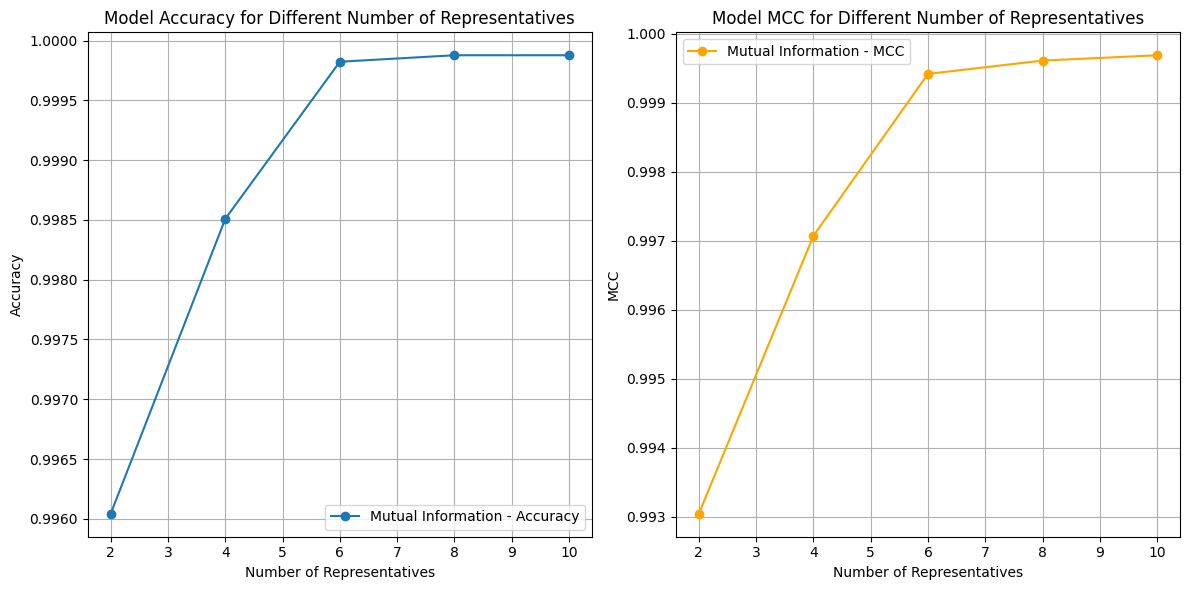

Explanation for the test instance:
Predicted label: 8
Predicted probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Contributions of each representative:
Representative 4: Contribution = 0.0127
Representative 5: Contribution = 0.3067
Representative 3: Contribution = 0.1415
Representative 0: Contribution = 0.1959
Representative 1: Contribution = 0.1917
Representative 2: Contribution = 0.1516


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import norm
import matplotlib.pyplot as plt
# Factor Analysis to extract latent variables
fa = FactorAnalysis(n_components=10, random_state=42)
X_train_fa = fa.fit_transform(x_train)
X_test_fa = fa.transform(x_test)
# Calculate feature importances using Mutual Information
def calculate_mutual_info_importances(X, y):
    return mutual_info_classif(X, y)

# Calculate feature importances using Mutual Information
mutual_info_indices = calculate_mutual_info_importances(X_train_fa, y_train)

# Function to build and train the Random Forest model
def build_and_train_rf(X_train, y_train, X_val, y_val):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return model, accuracy

# Evaluate the model for different number of top features
num_representatives = [2, 4, 6, 8, 10]
accuracies_mutual_info = []
mcc_scores = []

for k in num_representatives:
    top_k_indices = np.argsort(mutual_info_indices)[-k:]
    X_train_top_k = X_train_fa[:, top_k_indices]
    X_test_top_k = X_test_fa[:, top_k_indices]

    # Split train data into training and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_top_k, y_train, test_size=0.2, random_state=42)

    model, accuracy = build_and_train_rf(X_train_split, y_train_split, X_val_split, y_val_split)
    accuracies_mutual_info.append(accuracy)

    # Calculate MCC score for the test set
    y_pred_test = model.predict(X_test_top_k)
    mcc = matthews_corrcoef(y_test, y_pred_test)
    mcc_scores.append(mcc)

    print(f"Model accuracy with top {k} representatives (Mutual Information): {accuracy}")
    print(f"Model MCC with top {k} representatives (Mutual Information): {mcc}")

# Plot the accuracies and MCC scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(num_representatives, accuracies_mutual_info, marker='o', label='Mutual Information - Accuracy')
plt.xlabel('Number of Representatives')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for Different Number of Representatives')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(num_representatives, mcc_scores, marker='o', label='Mutual Information - MCC', color='orange')
plt.xlabel('Number of Representatives')
plt.ylabel('MCC')
plt.title('Model MCC for Different Number of Representatives')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# TRUST XAI: Generating explanations using Gaussian distribution for contributions
# def gaussian_contributions(num_representatives):
#     # Generate Gaussian-distributed contributions
#     mu, sigma = 0, 0.1  # mean and standard deviation
#     contributions = norm(mu, sigma).rvs(num_representatives)
#     contributions = np.abs(contributions)  # Make all contributions positive
#     contributions /= contributions.sum()  # Normalize to sum to 1
#     return contributions

# # Explanation for a single test instance
# k = 6  # You can adjust this value
# top_k_indices = np.argsort(mutual_info_indices)[-k:]
# X_train_top_k = X_train_fa[:, top_k_indices]
# X_test_top_k = X_test_fa[:, top_k_indices]

# # Re-train the RF model with top k representatives
# rf_model = RandomForestClassifier(random_state=42)
# rf_model.fit(X_train_top_k, y_train)

# # Select a single test instance
# test_instance = X_test_top_k[0].reshape(1, -1)
# predicted_label = rf_model.predict(test_instance)
# predicted_probabilities = rf_model.predict_proba(test_instance)

# # Calculate contribution of each representative using Gaussian distribution
# contributions = gaussian_contributions(k)

# # Output explanation
# print("Explanation for the test instance:")
# print(f"Predicted label: {predicted_label[0]}")
# print(f"Predicted probabilities: {predicted_probabilities[0]}")
# print("Contributions of each representative:")
# for idx, contribution in zip(top_k_indices, contributions):
#     print(f"Representative {idx}: Contribution = {contribution:.4f}")

# # Show the representatives chosen and their feature contributions
# representatives = fa.components_[top_k_indices]

# top_contributing_features = {}

# for idx, representative in zip(top_k_indices, representatives):
#     top_features = np.argsort(-np.abs(representative))[:5]  # Get top 5 contributing features
#     top_contributing_features[idx] = [(x.columns[feature_idx], representative[feature_idx]) for feature_idx in top_features]
#     print(f"\nRepresentative {idx}:")
#     for feature, contribution in top_contributing_features[idx]:
#         print(f"Feature: {feature}, Contribution: {contribution:.4f}")

# # Output the top contributing features for each representative
# for rep_idx, features in top_contributing_features.items():
#     print(f"\nTop contributing features for representative {rep_idx}:")
#     for feature, contribution in features:
#         print(f"Feature: {feature}, Contribution: {contribution:.4f}")

In [ ]:
def gaussian_contributions(num_representatives):
    # Generate Gaussian-distributed contributions
    mu, sigma = 0, 0.1  # mean and standard deviation
    contributions = norm(mu, sigma).rvs(num_representatives)
    contributions = np.abs(contributions)  # Make all contributions positive
    contributions /= contributions.sum()  # Normalize to sum to 1
    return contributions

# Explanation for a single test instance
k = 6  # You can adjust this value
top_k_indices = np.argsort(mutual_info_indices)[-k:]
X_train_top_k = X_train_fa[:, top_k_indices]
X_test_top_k = X_test_fa[:, top_k_indices]

# Re-train the RF model with top k representatives
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_top_k, y_train)

# Select a single test instance
test_instance = X_test_top_k[0].reshape(1, -1)
predicted_label = rf_model.predict(test_instance)
predicted_probabilities = rf_model.predict_proba(test_instance)

# Calculate contribution of each representative using Gaussian distribution
contributions = gaussian_contributions(k)

# Output explanation
print("Explanation for the test instance:")
print(f"Predicted label: {predicted_label[0]}")
print(f"Predicted probabilities: {predicted_probabilities[0]}")
print("Contributions of each representative:")
for idx, contribution in zip(top_k_indices, contributions):
    print(f"Representative {idx}: Contribution = {contribution:.4f}")

# Show the representatives chosen and their feature contributions
representatives = fa.components_[top_k_indices]

top_contributing_features = {}

# Assuming feature_names is a list of column names
feature_names = data.columns  # Replace this with the actual feature names if different

for idx, representative in zip(top_k_indices, representatives):
    top_features = np.argsort(-np.abs(representative))[:5]  # Get top 5 contributing features
    top_contributing_features[idx] = [(feature_names[feature_idx], representative[feature_idx]) for feature_idx in top_features]
    print(f"\nRepresentative {idx}:")
    for feature, contribution in top_contributing_features[idx]:
        print(f"Feature: {feature}, Contribution: {contribution:.4f}")

# Output the top contributing features for each representative
for rep_idx, features in top_contributing_features.items():
    print(f"\nTop contributing features for representative {rep_idx}:")
    for feature, contribution in features:
        print(f"Feature: {feature}, Contribution: {contribution:.4f}")

Explanation for the test instance:
Predicted label: 8
Predicted probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Contributions of each representative:
Representative 4: Contribution = 0.2185
Representative 5: Contribution = 0.0898
Representative 3: Contribution = 0.1467
Representative 0: Contribution = 0.2121
Representative 1: Contribution = 0.1635
Representative 2: Contribution = 0.1695

Representative 4:
Feature: src_ip_bytes, Contribution: 168824.7899
Feature: dst_ip_bytes, Contribution: 82024.1321
Feature: dst_bytes, Contribution: 1278.8026
Feature: src_pkts, Contribution: 388.4377
Feature: dst_pkts, Contribution: 368.9110

Representative 5:
Feature: dst_ip_bytes, Contribution: 156725.9477
Feature: src_ip_bytes, Contribution: -70432.7491
Feature: dst_bytes, Contribution: -1595.8068
Feature: dst_pkts, Contribution: 219.7703
Feature: src_port, Contribution: 152.3517

Representative 3:
Feature: dst_bytes, Contribution: 9016485.6913
Feature: src_ip_bytes, Contribution: -4015.7361
Feature

In [ ]:
x_wo = data.drop(['label'], axis=1).values
y_wo = data['label'].values
# scaling the dataset.
ro_scaler = RobustScaler()
x_wo_scaled = ro_scaler.fit_transform(x_wo)

scaler = MinMaxScaler()
x_wo_scaled = scaler.fit_transform(x_wo_scaled)
x_wo_train , x_wo_test , y_wo_train , y_wo_test = train_test_split(x_wo_scaled, y_wo, test_size= 0.2 , random_state=42)
xl_wo_test = data_test.drop(['label'], axis=1).values
yl_wo_test = data_test['label'].values
scaler = MinMaxScaler()
xl_wo_test = scaler.fit_transform(xl_wo_test)

x_traincpy = np.copy(x_wo_train)
y_traincpy = np.copy(y_wo_train)
x_testcpy = np.copy(x_wo_test)
y_testcpy = np.copy(y_wo_test)

random = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
random_cross = fit_and_evaluate(random, x_traincpy , x_testcpy , y_traincpy , y_testcpy)

print('Random Forest Performance on the test set: Cross Validation Score = %0.4f' % random_cross)
xl_testcpy = np.copy(xl_wo_test)
yl_testcpy = np.copy(yl_wo_test)

y_pred = random.predict(xl_testcpy)
print("Accuracy: ", accuracy_score(yl_testcpy, y_pred))


# Explain the model using LIME and SHAP
explainer_lime = explain_model(random, x_traincpy, 'lime')
explainer_shap = explain_model(random, x_traincpy, 'shap')

# Lime explanation
lime_explanation = explainer_lime.explain_instance(xl_testcpy[0], random.predict_proba, num_features=len(data.drop(['label'], axis=1).columns))
lime_explanation.show_in_notebook(show_table=True)

Random Forest Performance on the test set: Cross Validation Score = 1.0000
Accuracy:  0.9999901913664407


In [ ]:
explainer_shap = shap.TreeExplainer(random)
shap_values = explainer_shap.shap_values(x_testcpy)

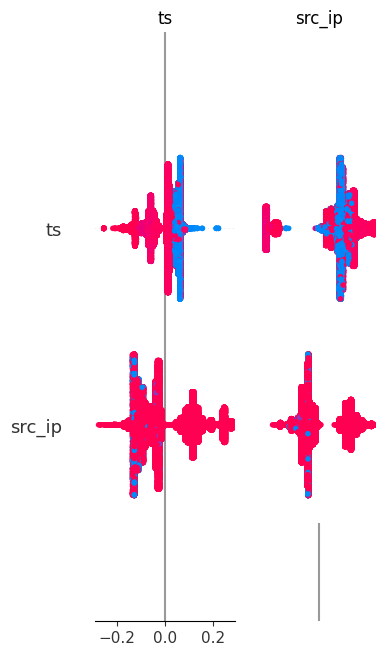

In [ ]:
explainer_shap = explain_model(random, x_traincpy, 'shap')
shap.summary_plot(shap_values, x_testcpy, feature_names=data.columns[:-1] , show=False)

# Save the plot as a file
plt.savefig('shap_rf_plot.png', dpi=300, bbox_inches='tight', pad_inches=0.2)

# Display the plot
img = plt.imread('shap_rf_plot.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import norm
import matplotlib.pyplot as plt

# Load NSL-KDD dataset
df = pd.read_csv('Train_Test_Network.csv', header=None)
df.columns =  ['ts',
 'src_ip',
 'src_port',
 'dst_ip',
 'dst_port',
 'proto',
 'service',
 'duration',
 'src_bytes',
 'dst_bytes',
 'conn_state',
 'missed_bytes',
 'src_pkts',
 'src_ip_bytes',
 'dst_pkts',
 'dst_ip_bytes',
 'dns_query',
 'dns_qclass',
 'dns_qtype',
 'dns_rcode',
 'dns_AA',
 'dns_RD',
 'dns_RA',
 'dns_rejected',
 'ssl_version',
 'ssl_cipher',
 'ssl_resumed',
 'ssl_established',
 'ssl_subject',
 'ssl_issuer',
 'http_trans_depth',
 'http_method',
 'http_uri',
 'http_version',
 'http_request_body_len',
 'http_response_body_len',
 'http_status_code',
 'http_user_agent',
 'http_orig_mime_types',
 'http_resp_mime_types',
 'weird_name',
 'weird_addl',
 'weird_notice',
 'label',
 'type']

# Map the labels to five categories: normal, dos, r2l, u2r, probe
# attack_types = {
#     'normal': 'normal',
#     'back': 'dos', 'land': 'dos', 'neptune': 'dos', 'pod': 'dos', 'smurf': 'dos', 'teardrop': 'dos', 'apache2': 'dos', 'udpstorm': 'dos', 'processtable': 'dos', 'worm': 'dos',
#     'ftp_write': 'r2l', 'guess_passwd': 'r2l', 'imap': 'r2l', 'multihop': 'r2l', 'phf': 'r2l', 'spy': 'r2l', 'warezclient': 'r2l', 'warezmaster': 'r2l', 'sendmail': 'r2l', 'named': 'r2l', 'snmpgetattack': 'r2l', 'snmpguess': 'r2l', 'xlock': 'r2l', 'xsnoop': 'r2l',
#     'buffer_overflow': 'u2r', 'loadmodule': 'u2r', 'perl': 'u2r', 'rootkit': 'u2r', 'httptunnel': 'u2r', 'ps': 'u2r', 'sqlattack': 'u2r', 'xterm': 'u2r',
#     'ipsweep': 'probe', 'mscan': 'probe', 'nmap': 'probe', 'portsweep': 'probe', 'saint': 'probe', 'satan': 'probe'
# }
# df['label'] = df['label'].map(attack_types)
df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'dos',inplace=True)
df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'r2l',inplace=True)
df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'probe',inplace=True)
df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'u2r',inplace=True)

# Encode the labels as integers
label_mapping = {'normal': 0, 'dos': 1, 'r2l': 2, 'u2r': 3, 'probe': 4}
df['label'] = df['label'].map(label_mapping)

# Splitting features and labels
X = df.drop(['label'], axis=1)
y = df['label']

# Check data types and handle categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
if not categorical_cols.empty:
    X = pd.get_dummies(X, columns=categorical_cols)

# Check for NaN values in the features
if X.isna().any().any():
    print("NaN values found in the features. Filling NaN values with 0.")
    X = X.fillna(0)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle missing values
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# Factor Analysis to extract latent variables
fa = FactorAnalysis(n_components=10, random_state=42)
X_train_fa = fa.fit_transform(X_train)
X_test_fa = fa.transform(X_test)

<ipython-input-1-028ee8c8328d>:13: DtypeWarning: Columns (0,2,4,7,8,9,11,12,13,14,15,17,18,19,34,35,36,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Train_Test_Network.csv', header=None)


In [ ]:
# Calculate feature importances using Mutual Information
def calculate_mutual_info_importances(X, y):
    return mutual_info_classif(X, y)

# Calculate feature importances using Mutual Information
mutual_info_indices = calculate_mutual_info_importances(X_train_fa, y_train)

# Function to build and train the Random Forest model
def build_and_train_rf(X_train, y_train, X_val, y_val):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return model, accuracy

# Evaluate the model for different number of top features
num_representatives = [2, 4, 6, 8, 10]
accuracies_mutual_info = []
mcc_scores = []

for k in num_representatives:
    top_k_indices = np.argsort(mutual_info_indices)[-k:]
    X_train_top_k = X_train_fa[:, top_k_indices]
    X_test_top_k = X_test_fa[:, top_k_indices]

    # Split train data into training and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_top_k, y_train, test_size=0.2, random_state=42)

    model, accuracy = build_and_train_rf(X_train_split, y_train_split, X_val_split, y_val_split)
    accuracies_mutual_info.append(accuracy)

    # Calculate MCC score for the test set
    y_pred_test = model.predict(X_test_top_k)
    mcc = matthews_corrcoef(y_test, y_pred_test)
    mcc_scores.append(mcc)

    print(f"Model accuracy with top {k} representatives (Mutual Information): {accuracy}")
    print(f"Model MCC with top {k} representatives (Mutual Information): {mcc}")

# Plot the accuracies and MCC scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(num_representatives, accuracies_mutual_info, marker='o', label='Mutual Information - Accuracy')
plt.xlabel('Number of Representatives')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for Different Number of Representatives')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(num_representatives, mcc_scores, marker='o', label='Mutual Information - MCC', color='orange')
plt.xlabel('Number of Representatives')
plt.ylabel('MCC')
plt.title('Model MCC for Different Number of Representatives')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# TRUST XAI: Generating explanations using Gaussian distribution for contributions
def gaussian_contributions(num_representatives):
    # Generate Gaussian-distributed contributions
    mu, sigma = 0, 0.1  # mean and standard deviation
    contributions = norm(mu, sigma).rvs(num_representatives)
    contributions = np.abs(contributions)  # Make all contributions positive
    contributions /= contributions.sum()  # Normalize to sum to 1
    return contributions

# Explanation for a single test instance
k = 6  # You can adjust this value
top_k_indices = np.argsort(mutual_info_indices)[-k:]
X_train_top_k = X_train_fa[:, top_k_indices]
X_test_top_k = X_test_fa[:, top_k_indices]

# Re-train the RF model with top k representatives
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_top_k, y_train)

# Select a single test instance
test_instance = X_test_top_k[0].reshape(1, -1)
predicted_label = rf_model.predict(test_instance)
predicted_probabilities = rf_model.predict_proba(test_instance)

# Calculate contribution of each representative using Gaussian distribution
contributions = gaussian_contributions(k)

# Output explanation
print("Explanation for the test instance:")
print(f"Predicted label: {predicted_label[0]}")
print(f"Predicted probabilities: {predicted_probabilities[0]}")
print("Contributions of each representative:")
for idx, contribution in zip(top_k_indices, contributions):
    print(f"Representative {idx}: Contribution = {contribution:.4f}")

# Show the representatives chosen and their feature contributions
representatives = fa.components_[top_k_indices]

top_contributing_features = {}

for idx, representative in zip(top_k_indices, representatives):
    top_features = np.argsort(-np.abs(representative))[:5]  # Get top 5 contributing features
    top_contributing_features[idx] = [(X.columns[feature_idx], representative[feature_idx]) for feature_idx in top_features]
    print(f"\nRepresentative {idx}:")
    for feature, contribution in top_contributing_features[idx]:
        print(f"Feature: {feature}, Contribution: {contribution:.4f}")

# Output the top contributing features for each representative
for rep_idx, features in top_contributing_features.items():
    print(f"\nTop contributing features for representative {rep_idx}:")
    for feature, contribution in features:
        print(f"Feature: {feature}, Contribution: {contribution:.4f}")